## Semisupervised learning
Using clusters to get few representative instances and then using them as labels to train the model (supervised learning)

In this notebook, we will be using _load_digits_ dataset 

In [99]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

In [100]:
np.random.seed(42)

In [101]:
X,y = load_digits(return_X_y=True)
X.shape

(1797, 64)

1797 images of 8x8 resolution

In [157]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [158]:
## Check with Logistic Regression without clustering
from sklearn.linear_model import LogisticRegression
n_labels = 50 #50 labelled images
log_reg = LogisticRegression(random_state=42)
log_reg.fit(x_train_scaled[:n_labels],y_train[:n_labels])

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [159]:
accuracy_score(y_test,log_reg.predict(x_test_scaled))

0.7981481481481482

In [162]:
#What would accuracy be if i use all labelled instances
log_reg_full = LogisticRegression(random_state=42)
log_reg_full.fit(x_train_scaled,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [163]:
accuracy_score(y_test,log_reg_full.predict(x_test_scaled))

0.9648148148148148

obviously its higher than when we used only 50 labelled instances

___What if we had no labelled instances?___  
- Choose number of appropriate cluster (here I thought that 50 might be good), (remember that you will have to label instances manually so pick clusters according to that)
- transform the original data into data of shape [n_samples,n_clusters], where each column is a cluster and its values is distance between instance and cluster
- Then for each cluster get an instance that is closest to it, that instance will be representative of its cluster
- Then pick those representative instances from original dataset
- plot the images, or get label of those representative instance somehow
- Now you have instances and labels!! train the supervised learning model!!

___Cant we just give labels to any random instances in the dataset and then train model?___  
We already tried that, see above, log_reg gave very less accuracy.   
So instead of labelling random instances we will label important instances

In [164]:
## Applying kmeans for semisupervised learning
from sklearn.cluster import KMeans

k=50 #Taking 50 clusters                            #step 1
kmeans= KMeans(n_clusters=k,init="k-means++",n_init=8,random_state=42)

x_digits_dist = kmeans.fit_transform(x_train)        #step 2 Transform dataset
x_representatives_idx = x_digits_dist.argmin(axis=0) #step 3 get idx of instance closest to its respective cluster

x_representative_digits = x_train[x_representatives_idx] #step 4

In [166]:
def plot_img(X):
    plt.axis("off")
    plt.imshow(X.reshape(8,8),cmap='binary')

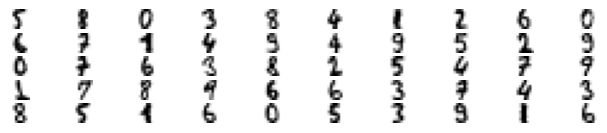

In [167]:
## Plot representative images 
plt.figure(figsize=(8,3))

for idx,img in enumerate(x_representative_digits):
    plt.subplot(10,10,1+idx)
    plot_img(img)

In [168]:
y_train_labels=np.array([    #step 5 Look at each image and mannually label it
 5,8,0,3,8,4,1,2,6,0,
 6,7,1,4,9,4,9,5,2,9,
 0,7,6,3,8,2,5,4,7,9,
 1,7,8,9,6,6,3,7,4,3,
 8,5,1,6,0,5,3,9,1,6
])


In [169]:
log_reg_semisup = LogisticRegression()
log_reg_semisup.fit(x_representative_digits,y_train_labels)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [170]:
accuracy_score(y_test,log_reg_semisup.predict(x_test))

0.9055555555555556

We just trained a supervised model and predicted instances without even using lables!!  
And its accuracy is more than the model trained on random labelled instances (log_reg)

### _Label Propagation_
Assigning labels of representative instances of a cluster to all instances in that cluster.   
This helps model to have more instances and generalize better

In [171]:
y_train_propagated = np.empty(shape=len(x_train),dtype=np.int64)

for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_train_labels[i]
    # kmeans.labels_ = [0,2,1,13,49,0,...] (index of cluster for each sample)

How that loop works:   


In [172]:
log_reg_propagated = LogisticRegression(max_iter=10000)
log_reg_propagated.fit(x_train,y_train_propagated)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [173]:
accuracy_score(y_test,log_reg_propagated.predict(x_test))

0.9277777777777778

Accuracy increased slightly!!   
The things about propagation is that, It might fail

#### I did not understood that partial propagation part!! Do it later

### Active learning
- We have some manually labelled instances right, Train model on those instances
- Then predict all unlabelled instances using that model
- Take out instances with least probability/confidence score
- Give those instances to experts and label them mannually
- Feed those instances again to model, train model on this new labelled dataset (previously labelled instances and these uncertain labelled instances)

`Now again, train model --> predict --> get most uncertain instances --> label them --> add them to training set --> train model again`

- Repeat this process until accuracy stop increasing 

In [174]:
## We have 50 labelled instances 
x_representative_digits, y_train_labels

(array([[ 0.,  2., 12., ...,  0.,  0.,  0.],
        [ 0.,  0.,  3., ...,  2.,  0.,  0.],
        [ 0.,  0.,  8., ...,  1.,  0.,  0.],
        ...,
        [ 0.,  0., 10., ..., 10.,  0.,  0.],
        [ 0.,  0.,  3., ...,  5.,  0.,  0.],
        [ 0.,  0.,  1., ..., 16., 11.,  0.]], shape=(50, 64)),
 array([5, 8, 0, 3, 8, 4, 1, 2, 6, 0, 6, 7, 1, 4, 9, 4, 9, 5, 2, 9, 0, 7,
        6, 3, 8, 2, 5, 4, 7, 9, 1, 7, 8, 9, 6, 6, 3, 7, 4, 3, 8, 5, 1, 6,
        0, 5, 3, 9, 1, 6]))

In [175]:
#train the model
log_reg = LogisticRegression()
log_reg.fit(x_representative_digits,y_train_labels)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [176]:
accuracy_score(y_test,log_reg.predict(x_test))

0.9055555555555556

In [ ]:
# Get probabilities 
y_proba = log_reg.predict_proba(x_train)
# An array of (n_testsamples,classes) (540,10)

y_proba_predicted_class = np.max(y_proba,axis=1)

In [178]:
print(y_proba.shape)
print(y_proba_predicted_class.shape)

(1257, 10)
(1257,)


In [182]:
# 50 Most uncertain instances index
uncertain_idx = np.argsort(y_proba_predicted_class)[:50]

# Most uncertain instances 
uncertain_instances = x_train[uncertain_idx]
uncertain_instances

array([[ 0.,  0.,  2., ..., 14.,  1.,  0.],
       [ 0.,  0., 10., ...,  6.,  0.,  0.],
       [ 0.,  1.,  3., ..., 14.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  8., ...,  2.,  0.,  0.],
       [ 0.,  4., 15., ...,  0.,  0.,  0.]], shape=(50, 64))

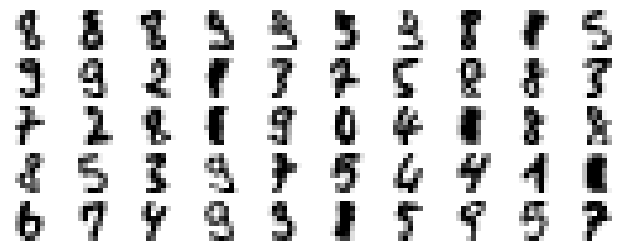

In [185]:
plt.figure(figsize=(8,3))

for idx,img in enumerate(uncertain_instances):
    plt.subplot(5,10,1+idx)
    plot_img(img)

even i cant recognise these images wtf   
But the thing is, if i label them incorrectly and then train model on that, model could be far off from correct prediction....because these are boderline digits and they decide final decision boundaries   

Lets try with these instances and then take some other uncertain instances but better than these atleast

In [ ]:
# Label them mannually
y_uncertain_labels = np.array([
    8,5,8,5,5,5,9,6,1,5,
    9,9,2,1,7,7,5,2,1,7,
    7,2,4,3,9,0,4,1,3,4,
    2,5,3,3,7,5,4,4,1,6,
    6,7,4,3,3,1,5,9,5,7
])

In [187]:
x_train_new = np.concatenate([x_representative_digits,uncertain_instances],axis=0)
y_train_new = np.concatenate([y_train_labels,y_uncertain_labels],axis=0)

In [193]:
log_reg_active = LogisticRegression(random_state=42,max_iter=10000)
log_reg_active.fit(x_train_new,y_train_new)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [194]:
accuracy_score(y_test,log_reg_active.predict(x_test))

0.8611111111111112

Active learning seems like it cant help us here   
Lets iterate and improve it!!

In [196]:
y_proba = log_reg_active.predict_proba(x_train)
# An array of (n_testsamples,classes) (540,10)

y_proba_predicted_class = np.max(y_proba,axis=1)
# 20 Most uncertain instances index
uncertain_idx = np.argsort(y_proba_predicted_class)[:20]

# Most uncertain instances 
uncertain_instances = x_train[uncertain_idx]

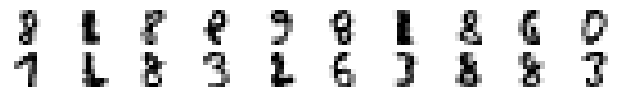

In [198]:
plt.figure(figsize=(8,1))

for idx,img in enumerate(uncertain_instances):
    plt.subplot(2,10,1+idx)
    plot_img(img)

In [203]:
y_uncertain_labels = np.array([
    8,1,7,8,9,8,2,8,6,0,
    1,6,2,3,2,6,3,8,8,3
])

x_train_new2 = np.concatenate([x_train_new,uncertain_instances],axis=0)
y_train_new2 = np.concatenate([y_train_new,y_uncertain_labels],axis=0)

In [204]:
log_reg_active2 = LogisticRegression(random_state=42,max_iter=10000)
log_reg_active2.fit(x_train_new2,y_train_new2)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [205]:
accuracy_score(y_test,log_reg_active2.predict(x_test))

0.8703703703703703

Accuracy increasedd!!!!    
We just have to do it multiple times until accuracy stops increasing